#### First, I figure out the phase/phi of one of the ITM mirrors to set the AS port dark for the carrier.

In [1]:
import finesse
finesse.configure(plotting=True)
prmi=finesse.Model()
prmi.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 
m pr R=0.85 T=0.15
s pr_Bs pr.p2 Bs.p1 

bs Bs R=0.5 T=0.5

#X-arm
s Lx Bs.p3 ITMx.p1 
m ITMx R=1 T=0

#Y-arm
s Ly Bs.p2 ITMy.p1
m ITMy R=1 T=0

pd AS_dc Bs.p4.o 
pd REFL_dc pr.p1.o
pd POP_dc pr.p2.o
pd Arm_trans ITMx.p2.o

xaxis(ITMx.phi,lin,-180,180,1000)

""")

C:\Users\91938\anaconda3\envs\finesse\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


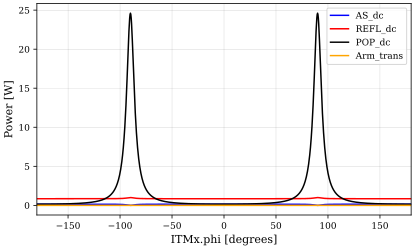

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>,
 'REFL_dc': <Figure size 576x355.968 with 1 Axes>,
 'POP_dc': <Figure size 576x355.968 with 1 Axes>,
 'Arm_trans': <Figure size 576x355.968 with 1 Axes>}

In [2]:
output=prmi.run()
output.plot()

#### The power buildup in the PRC is maximum when the ITMx is at phi=$\pm 90$ degrees.

In [3]:
prmi2=finesse.Model()
prmi2.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 
m pr R=0.85 T=0.15 
s pr_Bs pr.p2 Bs.p1 

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 
m ITMx R=0.9 T=0.1 phi=90            #Added that phi to the ITMx

#Y-arm
s Ly Bs.p2 ITMy.p1 
m ITMy R=0.9 T=0.1

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M

pd AS_dc Bs.p4.o 
pd REFL_dc pr.p1.o
pd POP_dc pr.p2.o
pd Arm_trans ITMx.p2.o


xaxis(pr.phi,lin,-180,180,1000)

""")

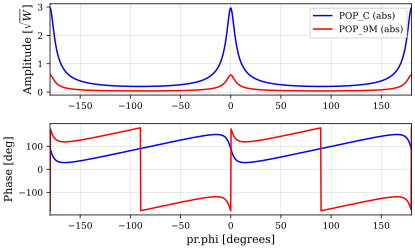

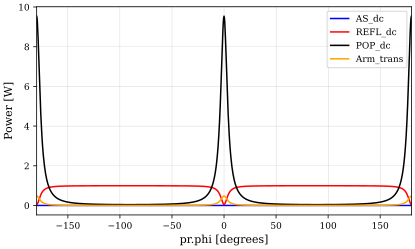

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>,
 finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>,
 'REFL_dc': <Figure size 576x355.968 with 1 Axes>,
 'POP_dc': <Figure size 576x355.968 with 1 Axes>,
 'Arm_trans': <Figure size 576x355.968 with 1 Axes>}

In [4]:
output=prmi2.run()
output.plot()

#### Adding random PRC length parameters (Lx,Ly,pr-bs)

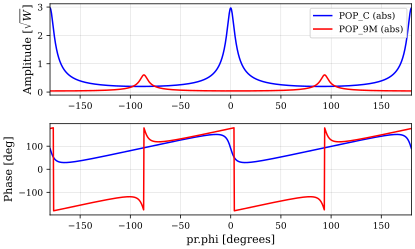

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>}

In [5]:
prmi3=finesse.Model()
prmi3.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15           
s pr_Bs pr.p2 Bs.p1 L=3  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(pr.phi,lin,-180,180,1000)

""")
output=prmi3.run()
output.plot()

#### Optimising the random value by varying the pr-bs length.

For L_pr_bs=3.0


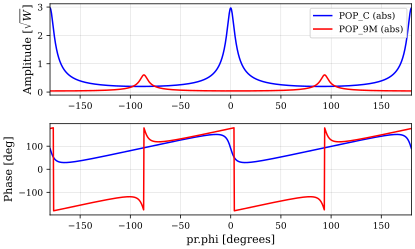

For L_pr_bs=3.025


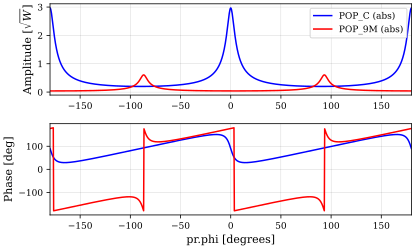

For L_pr_bs=3.05


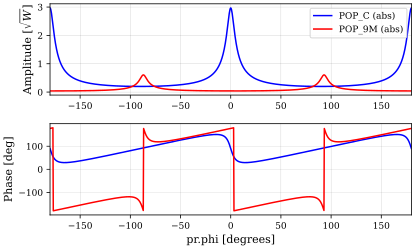

For L_pr_bs=3.075


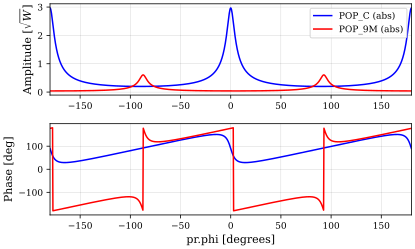

For L_pr_bs=3.1


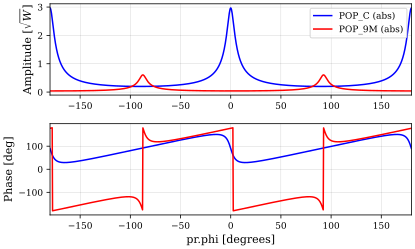

For L_pr_bs=3.125


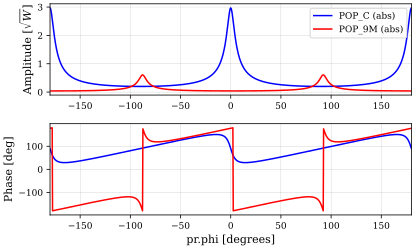

For L_pr_bs=3.15


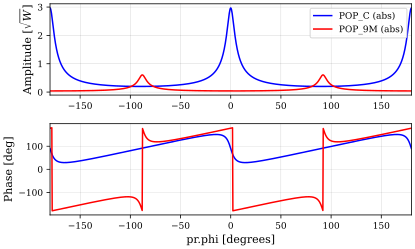

For L_pr_bs=3.175


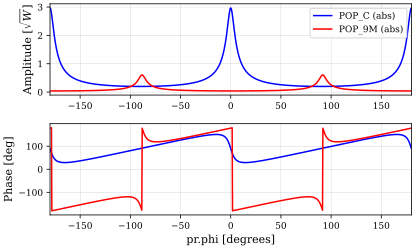

For L_pr_bs=3.2


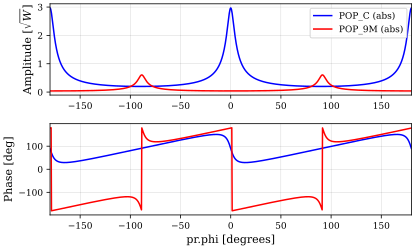

For L_pr_bs=3.225


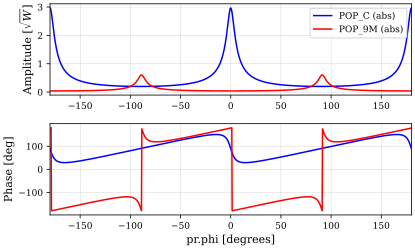

For L_pr_bs=3.25


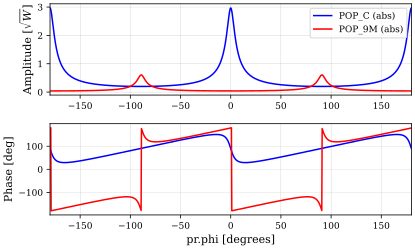

For L_pr_bs=3.275


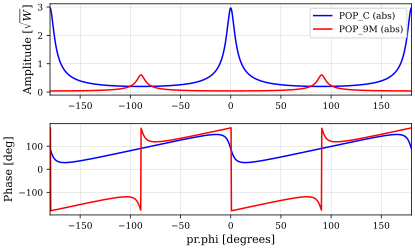

For L_pr_bs=3.3


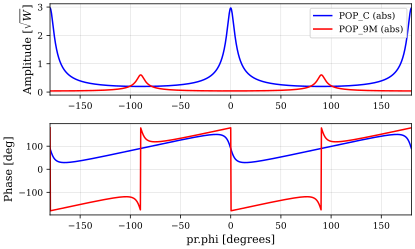

For L_pr_bs=3.325


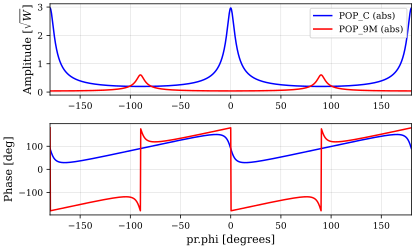

For L_pr_bs=3.35


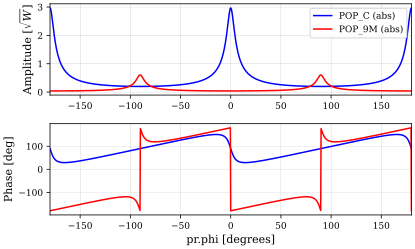

For L_pr_bs=3.375


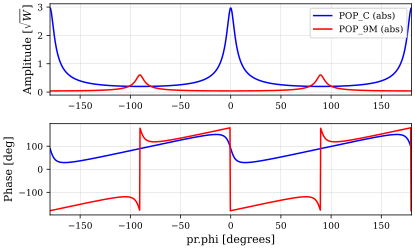

For L_pr_bs=3.4


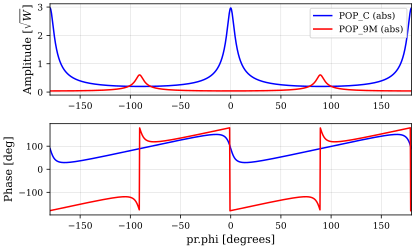

For L_pr_bs=3.425


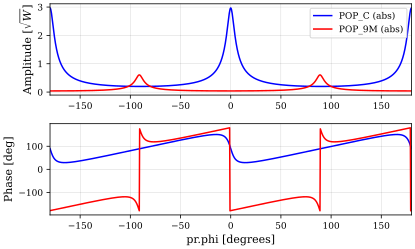

For L_pr_bs=3.45


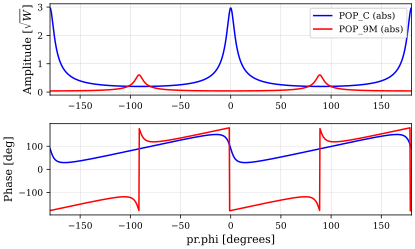

For L_pr_bs=3.475


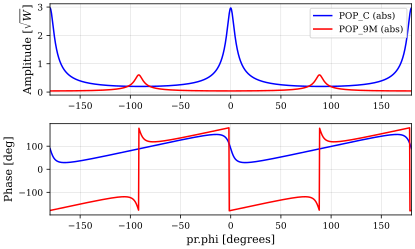

For L_pr_bs=3.5


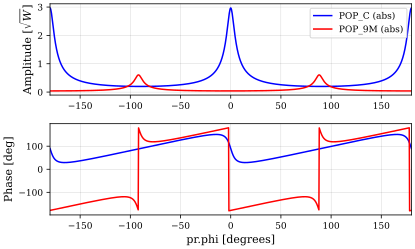

In [6]:
import numpy as np
for l in np.linspace(3,3.5,21):
    prmi_l=finesse.Model()
    prmi_l.parse(f"""
    l laser P=1
    s s0 laser.p1 eom.p1 
    mod eom midx=0.4 order=1 f=9M

    #PRM
    s s1 eom.p2 pr.p1 
    m pr R=0.85 T=0.15 
    s pr_Bs pr.p2 Bs.p1 L={l}

    bs Bs R=0.5 T=0.5 

    #X-arm
    s Lx Bs.p3 ITMx.p1 L=5
    m ITMx R=0.9 T=0.1 phi=90

    #Y-arm
    s Ly Bs.p2 ITMy.p1 L=5
    m ITMy R=0.9 T=0.1

    ad POP_C pr.p2.o f=0
    ad POP_9M pr.p2.o f=9M
    #ad AS_C Bs.p4.o f=0
    #ad AS_9M Bs.p4.o f=9M

    #pd AS_dc Bs.p4.o 
    #pd REFL_dc pr.p1.o
    #pd POP_dc pr.p2.o
    #pd Arm_trans ITMx.p2.o

    xaxis(pr.phi,lin,-180,180,1000)

    """)
    print(f"For L_pr_bs={l}")
    output=prmi_l.run()
    output.plot()

#### In the above cell, I have varied the the pr-bs length, (which was randomly chosen such that the SB resonance and C anti-res occur together, far from pr.phi=0) 
#### From the above analysis, we can set the pr-bs length as 3.35m. (better than a random 3m length, set before.)

#### The macroscopic PRC length changes cannot bring the necessary resonance of SB and Anti-Resonance of C, I am tuning the PRM, where the resonance of SB and anti-resonance of C occurs.

In [7]:
pr_bs_l_opt=3.35
prmi3=finesse.Model()
prmi3.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15           
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt}  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(pr.phi,lin,-180,180,1000)

""")

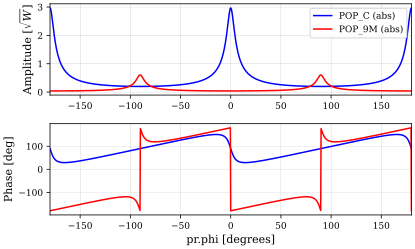

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>}

In [8]:
output1=prmi3.run()
output1.plot()

#### I will find the correct phi and set it as the phase of the PRM to get the necessary conditions.

In [9]:
Amplitude=[]
pr_phi=np.linspace(0,180,500) #avoiding the peak when pr.phi is negative at around -80 on the previous plot.
for i in range(500,1000,1):
    Amplitude.append(abs(output1["POP_9M"][i]))
max_amp=max(Amplitude)
pr_phi_opt=pr_phi[Amplitude.index(max_amp)]
print("pr_phi_opt:",pr_phi_opt)

pr_phi_opt: 89.81963927855712


#### I set this pr_phi to get the conditions.

In [10]:
prmi5=finesse.Model()
prmi5.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi={pr_phi_opt}          
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt}  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(Bs.phi,lin,-180,180,1000)
""")

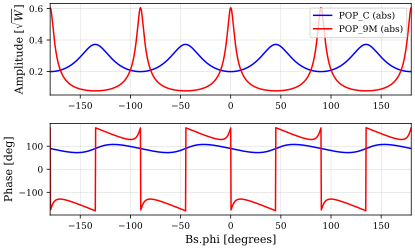

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>}

In [11]:
output=prmi5.run()
output.plot()

In [12]:
prmi6=finesse.Model()
prmi6.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi={pr_phi_opt}          
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt}  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

#ad POP_C pr.p2.o f=0
#ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(Bs.phi,lin,-180,180,1000)
""")

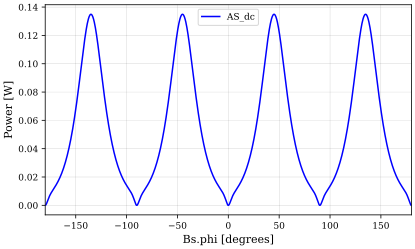

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>}

In [13]:
output=prmi6.run()
output.plot()

#### The DC readout at the AS port is zero, since it is dark for both C and SBs. We will need to set a Schnupp asymmetry to allow SB to AS port.
#### I will find the optimum Schnupp asymmetry that allows maximum SB transmission to the AS port. (It is done by finding the length parameters for which the AS_dc is maximum.

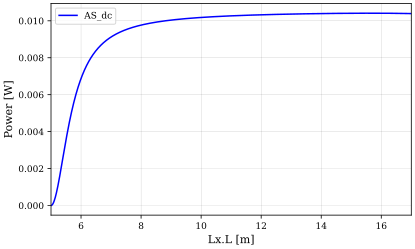

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>}

In [14]:
prmi6=finesse.Model()
prmi6.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi={pr_phi_opt}          
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt}  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

#ad POP_C pr.p2.o f=0
#ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(Lx.L,lin,5,17,1000)
""")
output=prmi6.run()
output.plot()

#### Current PRC length $= 3.35 +\frac{5+5}{2}=8.35 m$ 
#### The PRC length should not be changed in the process of optimization of the Schnupp asymmetry, otherwise the resonances will be disturbed.
#### But, we cannot fix PRC length as 8.35m, as the maximum power transmission at the AS port occurs at around Lx=16m. Therefore, the random initial PRC parameters have to be changed.
#### Lx=16 and Ly=5, or any combination(that would give a difference of 11m) would change the PRC. 

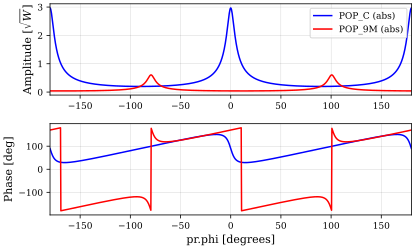

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>}

In [15]:
prmi6=finesse.Model()
prmi6.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15           
s pr_Bs pr.p2 Bs.p1 L=8

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=16
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=16
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(pr.phi,lin,-180,180,1000)
""")
output=prmi6.run()
output.plot()

#### I set new random PRC length parameters.

For L_pr_bs=8.0


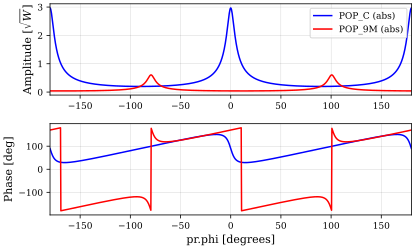

For L_pr_bs=8.05


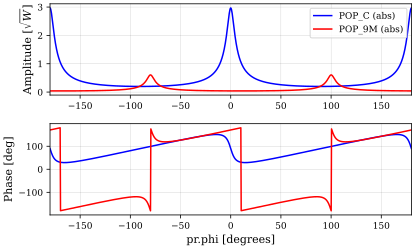

For L_pr_bs=8.1


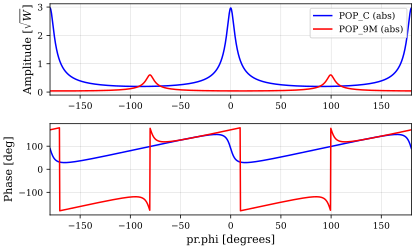

For L_pr_bs=8.15


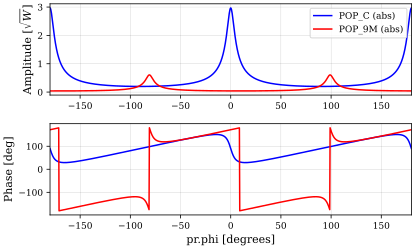

For L_pr_bs=8.2


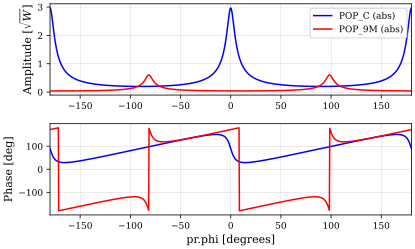

For L_pr_bs=8.25


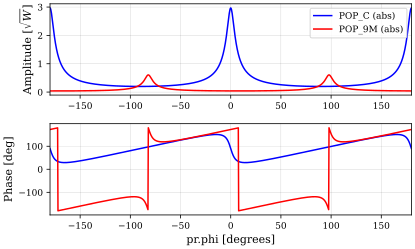

For L_pr_bs=8.3


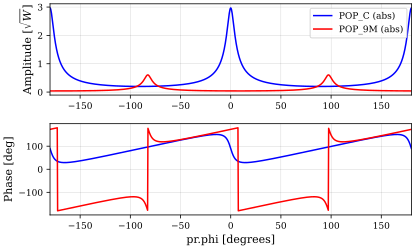

For L_pr_bs=8.35


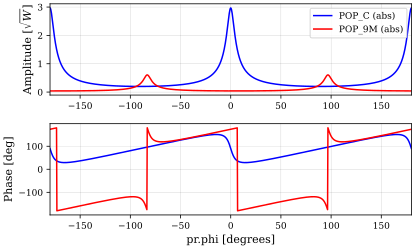

For L_pr_bs=8.4


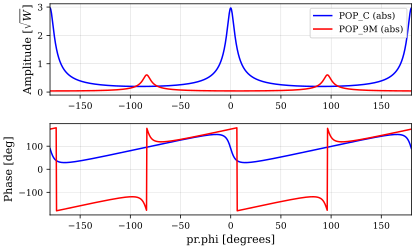

For L_pr_bs=8.45


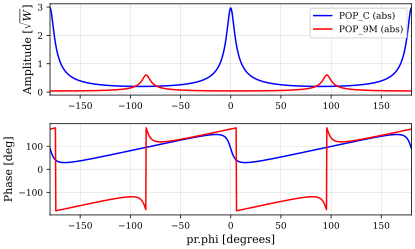

For L_pr_bs=8.5


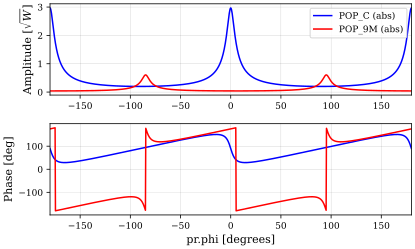

For L_pr_bs=8.55


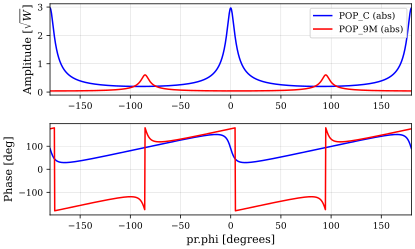

For L_pr_bs=8.6


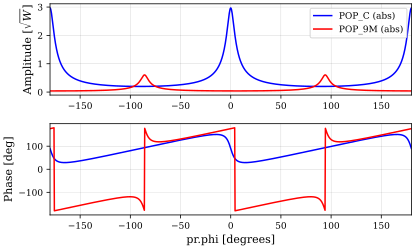

For L_pr_bs=8.65


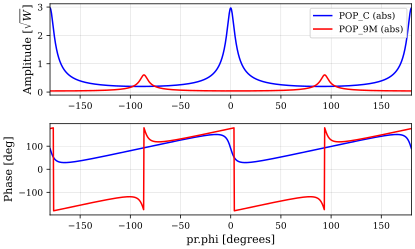

For L_pr_bs=8.7


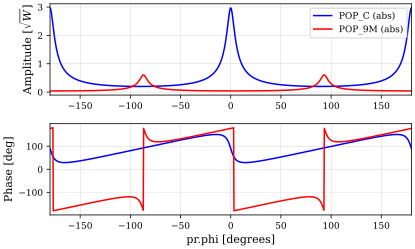

For L_pr_bs=8.75


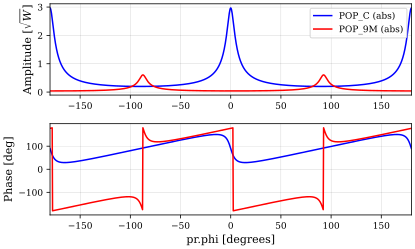

For L_pr_bs=8.8


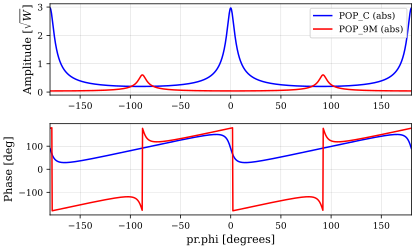

For L_pr_bs=8.85


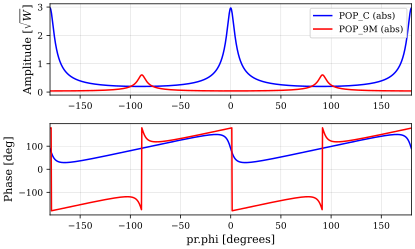

For L_pr_bs=8.9


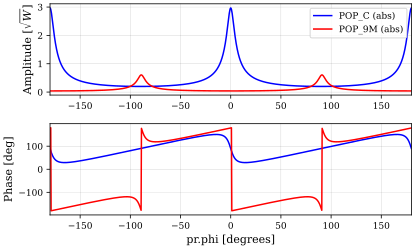

For L_pr_bs=8.95


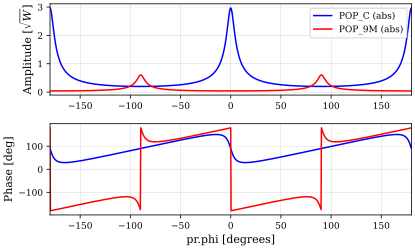

For L_pr_bs=9.0


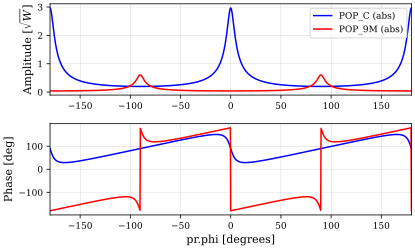

In [16]:
import numpy as np
for l in np.linspace(8,9,21):
    prmi_l=finesse.Model()
    prmi_l.parse(f"""
    l laser P=1
    s s0 laser.p1 eom.p1 
    mod eom midx=0.4 order=1 f=9M

    #PRM
    s s1 eom.p2 pr.p1 
    m pr R=0.85 T=0.15 
    s pr_Bs pr.p2 Bs.p1 L={l}

    bs Bs R=0.5 T=0.5 

    #X-arm
    s Lx Bs.p3 ITMx.p1 L=16
    m ITMx R=0.9 T=0.1 phi=90

    #Y-arm
    s Ly Bs.p2 ITMy.p1 L=16
    m ITMy R=0.9 T=0.1

    ad POP_C pr.p2.o f=0
    ad POP_9M pr.p2.o f=9M
    #ad AS_C Bs.p4.o f=0
    #ad AS_9M Bs.p4.o f=9M

    #pd AS_dc Bs.p4.o 
    #pd REFL_dc pr.p1.o
    #pd POP_dc pr.p2.o
    #pd Arm_trans ITMx.p2.o

    xaxis(pr.phi,lin,-180,180,1000)

    """)
    print(f"For L_pr_bs={l}")
    output=prmi_l.run()
    output.plot()

#### From the above analysis, we can set the pr-bs length as 8.95m (better than a random 8m length, set before.)

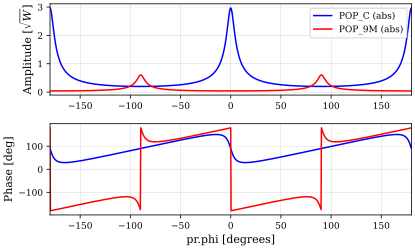

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>}

In [17]:
pr_bs_l_opt2=8.95
prmi6=finesse.Model()
prmi6.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15           
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt2}  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=16
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=16
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(pr.phi,lin,-180,180,1000)

""")
output2=prmi6.run()
output2.plot()

In [18]:
Amplitude=[]
pr_phi=np.linspace(0,180,500) #avoiding the peak when pr.phi is negative at around -80 on the previous plot.
for i in range(500,1000,1):
    Amplitude.append(abs(output2["POP_9M"][i]))
max_amp=max(Amplitude)
pr_phi_opt2=pr_phi[Amplitude.index(max_amp)]
print("pr_phi_opt:",pr_phi_opt2)

pr_phi_opt: 90.54108216432867


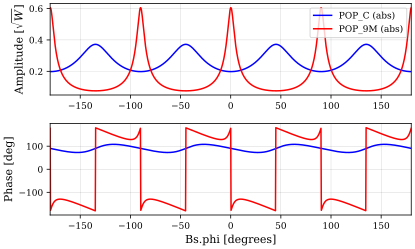

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>}

In [19]:
prmi7=finesse.Model()
prmi7.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi={pr_phi_opt2}         
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt2}  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=16
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=16
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(Bs.phi,lin,-180,180,1000)

""")
output2=prmi7.run()
output2.plot()

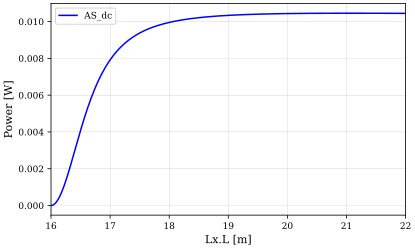

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>}

In [20]:
prmi7=finesse.Model()
prmi7.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi={pr_phi_opt2}          
s pr_Bs pr.p2 Bs.p1 L={pr_bs_l_opt2}

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=16
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=16
m ITMy R=0.9 T=0.1

pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

#ad POP_C pr.p2.o f=0
#ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

xaxis(Lx.L,lin,16,22,1000)
""")
output=prmi7.run()
output.plot()

#### Current PRC length $= 8.95 +\frac{16+16}{2}=24.95 m$ 
#### The PRC length should not be changed in the process of optimization of the Schnupp asymmetry, otherwise the resonances will be disturbed.
#### The power transmission to the AS port is maximum at around Lx=21 m, I will now change the PR-bs distance accordingly so that the Lx and Ly are similar, having the same PRC length of 24.95m.

#### First, I will find, precisely the length Lx for which the Power transmission is maximum.


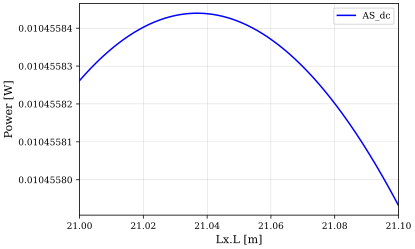

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>}

In [24]:
#Doing a much finer scan->
prmi7.parse("xaxis(Lx.L,lin,21,21.1,1000)")
output=prmi7.run()
output.plot()

In [26]:
import numpy as np
Lx_l=np.linspace(21,21.1,1000)
AS_dc=[]
for i in range(1000):
    AS_dc.append(output["AS_dc"][i])
max_AS_dc=max(AS_dc)
Lx_l_opt2=Lx_l[AS_dc.index(max_AS_dc)]
print(Lx_l_opt2)

21.036936936936936


#### The difference 21.037-16 has to be distributed to the Lx,pr-bs and Ly, such that the resonances are not disturbed.
#### I set the pr-bs length as 8.95-5=3.95m and setting the Lx and Ly length as 21m with 0.37m as their total asymmetry.

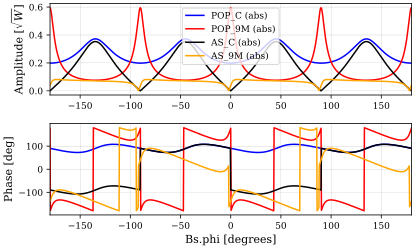

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>,
 'AS_C': <Figure size 576x355.968 with 2 Axes>,
 'AS_9M': <Figure size 576x355.968 with 2 Axes>}

In [27]:
prmi_final=finesse.Model()
prmi_final.parse(f"""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi={pr_phi_opt2}          
s pr_Bs pr.p2 Bs.p1 L=3.95

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=21+0.185
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=21-0.185
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
ad AS_C Bs.p4.o f=0
ad AS_9M Bs.p4.o f=9M

xaxis(Bs.phi,lin,-180,180,1000)
""")
out=prmi_final.run()
out.plot()